In [1]:
from src.experiments.novelty_sweep import run_novelty_sweep

output_csv = "novelty_sweep_genre.csv"
df_nov = run_novelty_sweep(output_csv=output_csv)
df_nov

[INFO] Novelty sweep on 3000 users (train_in rows = 132505, train_out rows = 3000)
[INFO] Evaluating baseline (lambda_nov = 0)


Sweeping novelty λ: 100%|██████████| 10/10 [00:44<00:00,  4.40s/it]

[INFO] Saved novelty sweep results to: /home/sunaj/Desktop/novelty-aware-recommenders/results/sweeps/novelty_sweep_genre.csv


,ndcg,recall,user_coverage,item_gini,publisher_gini,item_coverage,intra_list_similarity,novelty,ease_lambda_reg,novelty_lambda
0,0.227827,0.419667,1.0,0.822546,0.824697,0.127237,0.456593,0.552569,100,0.00
1,0.225057,0.410333,1.0,0.824660,0.827421,0.136275,0.404647,0.595278,100,0.05
2,0.219740,0.399000,1.0,0.822261,0.828372,0.142477,0.363778,0.630059,100,0.10
3,0.207276,0.376333,1.0,0.815594,0.828313,0.146199,0.298448,0.685434,100,0.20
4,0.193926,0.349333,1.0,0.811143,0.827086,0.146199,0.250782,0.728916,100,0.30
5,0.165909,0.301333,1.0,0.810154,0.828880,0.146199,0.208349,0.781420,100,0.50
6,0.141894,0.270000,1.0,0.814099,0.833245,0.149743,0.198818,0.807905,100,0.70
7,0.114942,0.229000,1.0,0.817912,0.836404,0.152933,0.198437,0.827732,100,1.00
8,0.088689,0.195000,1.0,0.821970,0.841129,0.156477,0.202285,0.841817,100,1.50
9,0.075665,0.171333,1.0,0.823519,0.841770,0.158958,0.205847,0.847360,100,2.00


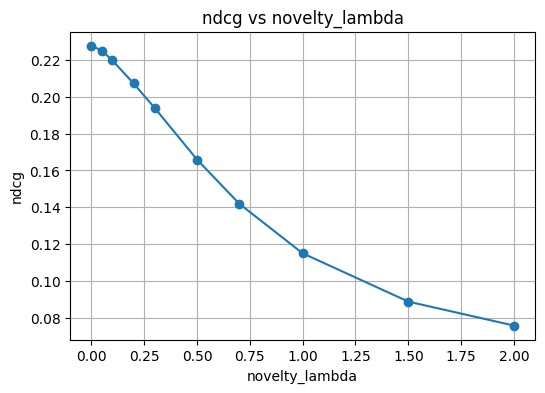

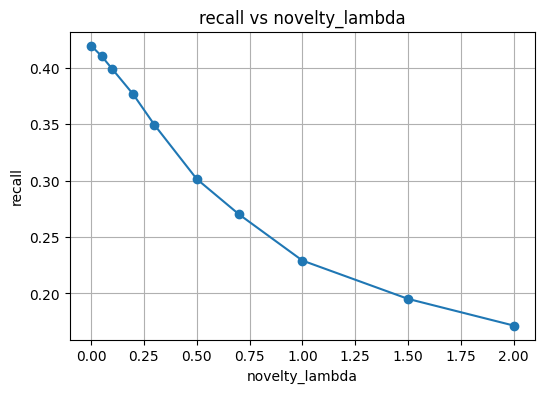

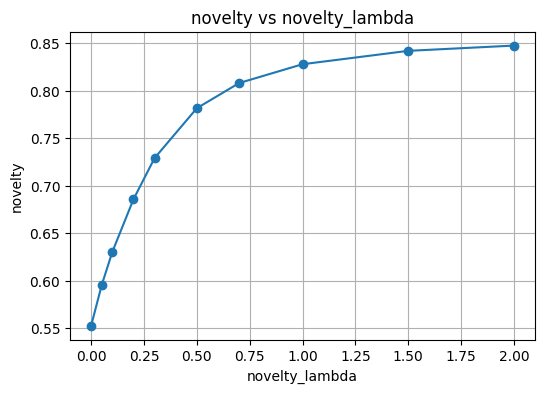

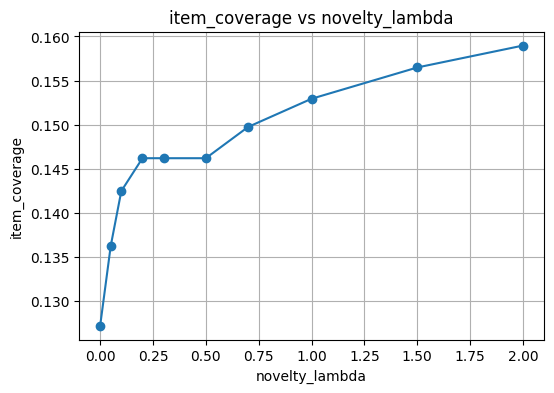

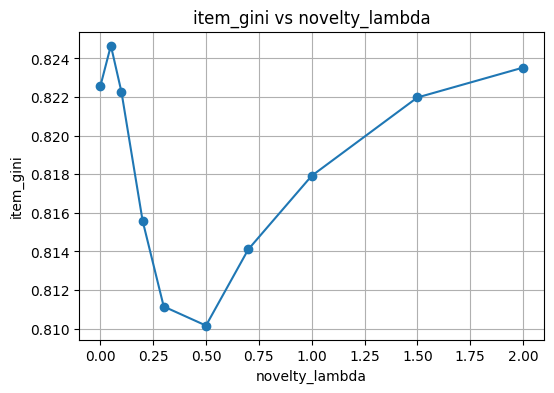

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("../results/sweeps/novelty_sweep_genre.csv")

# sort by novelty_lambda to get smooth curves
df = df.sort_values("novelty_lambda")

# 1) Lambda vs metrics
for metric in ["ndcg", "recall", "novelty", "item_coverage", "item_gini"]:
    plt.figure(figsize=(6,4))
    plt.plot(df["novelty_lambda"], df[metric], marker="o")
    plt.xlabel("novelty_lambda")
    plt.ylabel(metric)
    plt.title(f"{metric} vs novelty_lambda")
    plt.grid(True)
    plt.show()

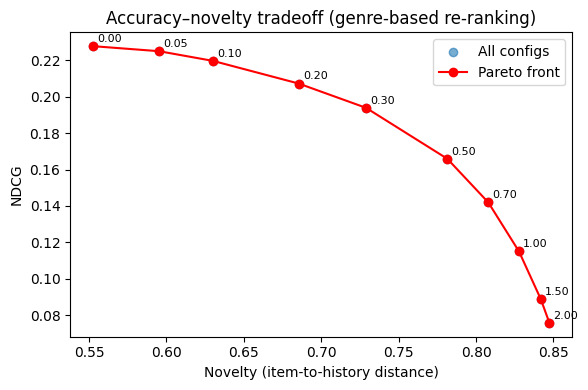

In [3]:
import matplotlib.pyplot as plt

x = df["novelty"]
y = df["ndcg"]
lam = df["novelty_lambda"]

plt.figure(figsize=(6, 4))
plt.scatter(x, y, label="All configs", alpha=0.6)

# draw Pareto curve
pareto = df.sort_values("novelty")
plt.plot(pareto["novelty"], pareto["ndcg"], "r-o", label="Pareto front")

# annotate each point with λ
for xv, yv, lv in zip(x, y, lam):
    plt.annotate(
        f"{lv:.2f}",
        (xv, yv),
        textcoords="offset points",
        xytext=(3, 3),
        fontsize=8,
    )

plt.xlabel("Novelty (item-to-history distance)")
plt.ylabel("NDCG")
plt.title("Accuracy–novelty tradeoff (genre-based re-ranking)")
plt.legend()
plt.tight_layout()
plt.show()


#### Conclusion
- I fixed the EASE regularization at λ_reg = 100 and reranked its top 100 candidates per user using a global genre-based novelty weight `novelty_lambda`.
- increasing `novelty_lambda` increases novelty metric (from about 0.55 to 0.85) and slightly improves item coverage.
- At the same time, increasing `novelty_lambda` decreases accuracy (NDCG drops from about 0.228 to 0.075).
- The accuracy–novelty Pareto curve is strictly decreasing and smooth, so each value of novelty_lambda corresponds to a different compromise.

In [ ]:
from src.data.loader import load_interactions, load_games
from src.models.ease import EASE
from src.novelty.rerank import rerank_with_novelty
from src.pipelines.save import save_submission
import numpy as np
from src.config import LAMBDA_REG

# 1. Load Codabench splits
train = load_interactions(train=True)
test_in = load_interactions(train=False)
games = load_games()

# 2. Load precomputed genre distance
item_distance = np.load("../data/processed/genre_distance.npy")

# 3. Train EASE with fixed lambda_reg
model = EASE(lambda_reg=LAMBDA_REG)

# recommend() already uses a Codabench style mapping
recs_base = model.recommend(train, test_in, top_k=100)

In [ ]:
# 4. Pick a novelty weight, for example, 0.3
NOVELTY_LAMBDA = 1.5

# re-rank scores
recs_novel = rerank_with_novelty(
    recs_base,
    test_in,
    item_distance,
    lambda_val=NOVELTY_LAMBDA,
)

# keep only top-20 per user, sorted by score
recs_novel = (
    recs_novel
    .sort_values(["user_id", "score"], ascending=[True, False])
    .groupby("user_id")
    .head(20)
    .reset_index(drop=True)
)

# drop scores for submission
submission = recs_novel[["user_id", "item_id"]]

# 5. Save for Codabench
save_submission(submission, f"ease_lambda100_nov_{NOVELTY_LAMBDA}")